**Student:** Diego Mazzieri  
**Matriculation Number:** 0000920452  
**Degree Programme:** Artificial Intelligence  
**Course:** Image Processing and Computer Vision  
**Professor:** Luigi Di Stefano  

For the **specifications** of the project you can look at the **Visual_Inspection_of_Connecting_Rods_Project.pdf** file.

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

# First Task

The **images** are supposed to contain **only rods** **not overlapping** each other and **without** any type of **noise**, which in this context can be represented by iron powder.

For each rod present in the image some useful **information** must be **extracted**, specifically:

* **Type:** depending on the number of holes of the rod, 1 hole -> A, 2 holes -> B;
* **Position:** the coordinates of the barycenter of the rod;
* **Orientation:** the angle in degrees between the rod major axis and the horizontal axis;
* **Length:** dimension of the rod along the major axis;
* **Width:** dimension of the rod along the minor axis;
* **Width at the barycenter:** width of the rod in correspondence of its barycenter;
* **Holes:** position of the center and size of the diameter for each of the rod holes.

The **pool of images** corresponding to the prerequisites of the first task are listed below.

In [43]:
path = "../images/"
images_name = ["TESI00.BMP", "TESI01.BMP", "TESI12.BMP", "TESI21.BMP", "TESI31.BMP", "TESI33.BMP"]

For the sake of simplicity, we will see the system in action on only one of these images, but the process can be repeated for the others simply changing the index of the image to select. 

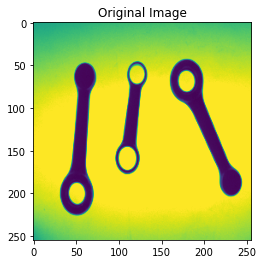

In [44]:
idx = 0
image_path = path + images_name[idx]
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.title("Original Image")
plt.imshow(image);

The first step is to **transform** the provided **greyscale image** into a **binary image** where the **rods**, representing the **foreground (255)**, are clearly **separated** from the **background**.  
Since the system should work properly under **any light conditions**, the technique adopted for the **binarization** is the **Otsu's algorithm** which doesn't involve the selection of a threshold but automatically selects the one which minimizes the gray-level range of the two regions.

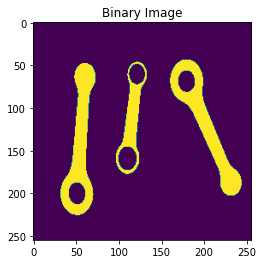

In [45]:
_, bin_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.title("Binary Image")
plt.imshow(bin_image);

Apart from this step, which we will discuss deeper in the second task, the **implementation** intentionally follows an **Object Oriented approach** to ensure the **separation of concerns** between the single parts of the system.

An image is likely to contain **more than one rod** and the presence of the others can **hamper** the **computation of the characteristics** of interest of the **single rod**, therefore it can be useful to create **as many binary images as rods** in the original one.  
This result can be achieved by detecting the **connected components** of the binary image and then **transforming in background** all the rods whose label is not the one of interest.

In [46]:
class RodsInspector:
    def __init__(self, bin_image, connectivity=4):
        self.num_labels, self.labelled_image, self.stats, self.centroids = \
            cv2.connectedComponentsWithStats(bin_image, connectivity, cv2.CV_32S)

    def isolate(self, label):
        rod = self.labelled_image.copy()
        rod[self.labelled_image == label] = 255
        rod[self.labelled_image != label] = 0
        return rod

    def isolate_all(self):
        labels = np.unique(self.labelled_image)
        # Ideally the largest connected component is the background
        background_label = np.argmax(self.stats[:, 4])
        # and therefore must be excluded from the rod labels
        rod_labels = labels[labels != background_label]
        rod_images = []
        for label in rod_labels:
            rod_images.append(self.isolate(label))
        return zip(rod_labels, rod_images)

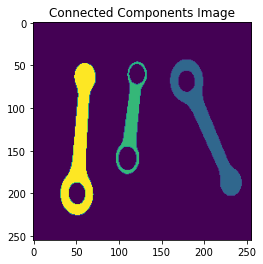

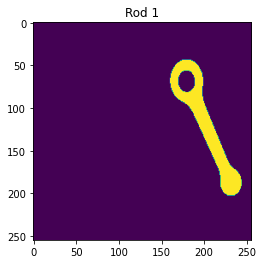

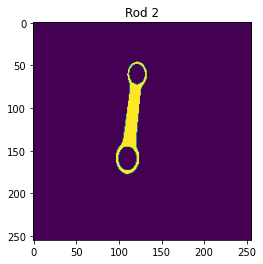

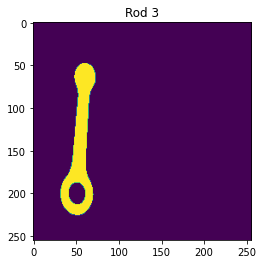

In [47]:
rods_insp = RodsInspector(bin_image)

plt.title("Connected Components Image")
plt.imshow(rods_insp.labelled_image)

for label, rod_image in rods_insp.isolate_all():
    plt.figure()
    plt.title("Rod {}".format(label))
    plt.imshow(rod_image);

After having **isolated** every **rod**, you can **start manipulating** the image in order to **obtain** all the **desired characteristics**.

## Type

The type of rod is given by its **number of holes** so fastest way to determine it is by finding them inside the image.  
One possible solution is to use another time the **connected components** but this time on the **negative** of the **binary image**.

In [48]:
class Rod:
    def __init__(self, rod_image):
        self.image = rod_image

    def type(self):
        holes_image = np.array(255 - self.image, dtype=np.uint8)
        holes_num_labels, holes_labelled_image, holes_stats, holes_centroids = \
            cv2.connectedComponentsWithStats(holes_image, cv2.CV_32S, connectivity=4)
        
        plt.figure()
        plt.imshow(holes_labelled_image)
        
        num_holes = len(np.unique(holes_labelled_image))
        # Don't consider the background and the rod
        num_holes -= 2
        
        if num_holes == 1:
            return "A"
        elif num_holes == 2:
            return "B"
        else:
            raise Exception("Not corresponding to any rod type")

Rod 1 -> Type A
Rod 2 -> Type B
Rod 3 -> Type A


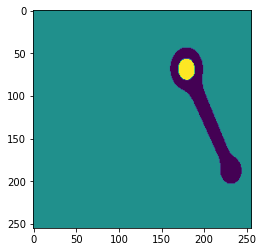

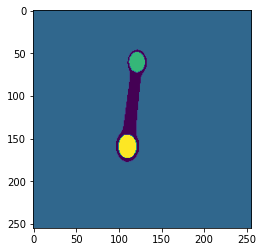

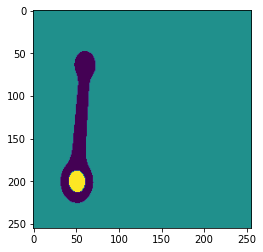

In [49]:
for label, rod_image in rods_insp.isolate_all():
    print("Rod {} -> Type {}".format(label, Rod(rod_image).type()))

## Holes

The **center** and the **diameter** of the holes can be computed by slightly changing the already provided `type` function. In fact, **thanks to** the `connectedComponentsWithStats` function, we already have all the holes properties we need; the only shrewdness is to **exclude** the **rod and background labels**.

In [50]:
class Rod:
    def __init__(self, rod_image):
        self.image = rod_image

    def type(self):
        holes_image = np.array(255 - self.image, dtype=np.uint8)
        holes_num_labels, holes_labelled_image, holes_stats, holes_centroids = \
            cv2.connectedComponentsWithStats(holes_image, cv2.CV_32S, connectivity=4)
        
        # Don't consider the background and the rod,
        # which are ideally the connected components with largest area
        ignored_labels = (np.argsort(holes_stats[:, 4])[::-1])[0:2]
        true_holes_labels = set(np.unique(holes_labelled_image)) - set(ignored_labels)
        
        holes = []
        plt.figure()
        for label in true_holes_labels:
            center = holes_centroids[label]
            diameter = math.sqrt((holes_stats[label, 4] / math.pi)) * 2
            holes.append({"label": label-1, "center": center, "diameter": diameter})
            plt.plot(center[0], center[1], 'o')
        plt.imshow(holes_labelled_image)
        
        if len(true_holes_labels) == 1:
            return "A", holes
        elif len(true_holes_labels) == 2:
            return "B", holes
        else:
            raise Exception("Not corresponding to any rod type")

Rod 1 -> Type A:
	- Hole 1 -> Center = [179.00777202  68.75647668], Diameter = 22.16913314200113
Rod 2 -> Type B:
	- Hole 1 -> Center = [121.14327485  60.35087719], Diameter = 20.867389014906145
	- Hole 2 -> Center = [109.95670996 158.97186147], Diameter = 24.253590861306396
Rod 3 -> Type A:
	- Hole 1 -> Center = [ 50.96632124 199.93264249], Diameter = 22.16913314200113


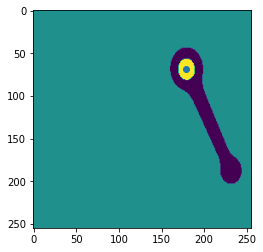

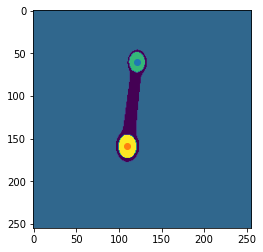

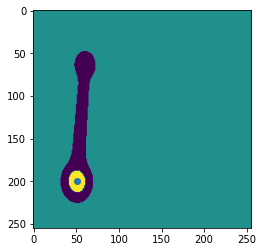

In [51]:
for label, rod_image in rods_insp.isolate_all():
    rod_type, holes = Rod(rod_image).type()
    print("Rod {} -> Type {}:".format(label, rod_type))
    for hole in holes:
        print("\t- Hole {} -> Center = {}, Diameter = {}".format(hole['label'], hole['center'], hole['diameter']))

## Position

The position of the rod is **given by** its **barycenter** which is **already computed** by the `connectedComponentsWithStats` function in the constructor of `RodsInspector`.  
We only need to create `Rod` objects inside the inspector and pass the centroid as an additional argument to their constructor.

In [52]:
class Rod:
    def __init__(self, label, rod_image, rod_centroid):
        self.label = label
        self.image = rod_image
        self.position = rod_centroid
        
    # ...

In [53]:
class RodsInspector:
    def __init__(self, bin_image, connectivity=4):
        self.num_labels, self.labelled_image, self.stats, self.centroids = \
            cv2.connectedComponentsWithStats(bin_image, connectivity, cv2.CV_32S)

    def isolate(self, label):
        rod = self.labelled_image.copy()
        rod[self.labelled_image == label] = 255
        rod[self.labelled_image != label] = 0
        return rod

    def isolate_all(self):
        labels = np.unique(self.labelled_image)
        # Ideally the largest connected component is the background
        background_label = np.argmax(self.stats[:, 4])
        # and therefore must be excluded from the rod labels
        rod_labels = labels[labels != background_label]
        rod_images = []
        for label in rod_labels:
            rod_images.append(self.isolate(label))
        return zip(rod_labels, rod_images)
    
    def analyze(self):
        rods_info = []
        for label, image in self.isolate_all():
            rods_info.append(Rod(label, image, self.centroids[label]))
        return rods_info

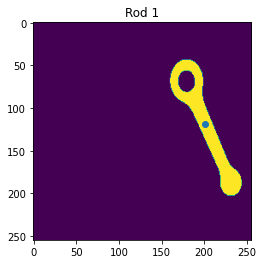

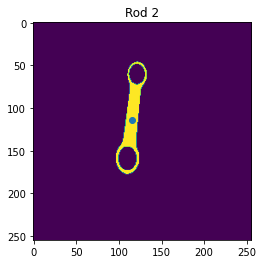

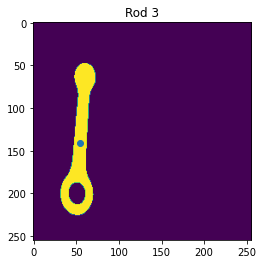

In [54]:
rods_insp = RodsInspector(bin_image)

for rod in rods_insp.analyze():
    plt.figure()
    plt.title("Rod {}".format(rod.label))
    plt.imshow(rod.image)
    plt.plot(rod.position[0], rod.position[1], 'o')

## Orientation

The computation of the orientation of the rod can be **derived from** the **covariance matrix** of the image.  
Given the concept of **central moment** of a region as $M'_{m, n} = \sum_{p \in R} (i - i_{b})^{m}(j - j_{b})^{n}$, where $(i_{b}, j_{b})$ are the coordinates of the barycenter, the covariance matrix can be determined using the following formulas:

$$ \sigma_{ii}^2 = \frac{M'_{2,0}}{A} \qquad \sigma_{jj}^2 = \frac{M'_{0,2}}{A} \qquad \sigma_{ij}^2 = \frac{M'_{1,1}}{A} $$

$$ 
\Sigma = 
    \begin{pmatrix}
        \sigma_{ii}^2 & \sigma_{ij}^2 \\
        \sigma_{ij}^2 & \sigma_{jj}^2 \\
    \end{pmatrix}
$$

In [55]:
def moment(region, m, n):
    height, width = region.shape
    j_coords, i_coords = np.mgrid[:height, :width]
    return (region * i_coords ** m * j_coords ** n).sum()


def central_moment(region, m, n, barycenter):
    height, width = region.shape
    j_coords, i_coords = np.mgrid[:height, :width]
    return (region * (i_coords - barycenter[0]) ** m * (j_coords - barycenter[1]) ** n).sum()


def covariance_matrix(region, barycenter):
    area = moment(region, 0, 0)
    sigma_ii = central_moment(region, 2, 0, barycenter) / area
    sigma_jj = central_moment(region, 0, 2, barycenter) / area
    sigma_ij = central_moment(region, 1, 1, barycenter) / area
    return np.array([[sigma_ii, sigma_ij], [sigma_ij, sigma_jj]])

The angle $\theta$ representing the orientation can be computed using the equation below, where the terms inside the $arctan$ can be substituted with the corresponding elements in the covariance matrix since the area $A$, appearing both at the numerator and at the denominator, can be  simplified.

$$ \theta = -\frac{1}{2}arctan(\frac{2M'_{1,1}}{M'_{0,2} - M'_{2,0}})$$

In [56]:
class Rod:
    def __init__(self, label, rod_image, rod_centroid):
        self.label = label
        self.image = rod_image
        self.position = rod_centroid
        self.covariance = covariance_matrix(self.image, self.position)
    
    # ...
    
    def orientation(self):
        theta = -0.5 * math.atan2((2 * self.covariance[0, 1]), (self.covariance[0, 0] - self.covariance[1, 1]))
        return math.degrees(theta)

Rod 1 -> Orientation = -66.80659680708865°
Rod 2 -> Orientation = 83.509364849678°
Rod 3 -> Orientation = 86.00214307442056°


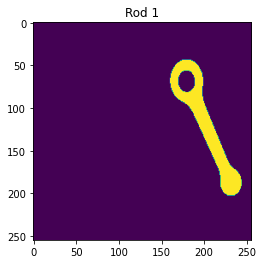

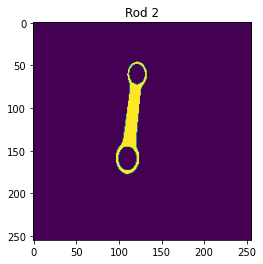

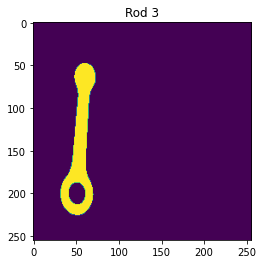

In [57]:
for rod in rods_insp.analyze():
    plt.figure()
    plt.title("Rod {}".format(rod.label))
    plt.imshow(rod.image)
    print("Rod {} -> Orientation = {}°".format(rod.label, rod.orientation()))

## Length & Width

The **length** and the **width** of a rod can be **computed simultaneously** determining the **Mininum Enclosing Rectangle** of the object.  
However, MER computation **requires** determining the **major and minor axes** first and like before, we can **use** the **covariance matrix** to obtain them. In fact, covariance matrix is always diagonalizable since it is symmetric semi-positive definite and its **eigenvectors** correspond exactly to the major (largest eigenvalue) and minor (lower eigenvalue) axes of the rod.  
Since the two axes are perpendicular and intersect in the barycenter, you can use one of them to determine the other and viceversa. Defining as $\alpha$ and $\beta$ the vector components of the major axis, we can obtain the equation of both the axes as:

$$major\_axis \to \alpha j - \beta i + \beta i_{b} - \alpha j_{b} = 0 \qquad minor\_axis \to \beta j + \alpha i - \beta j_{b} - \alpha i_{b} = 0$$

With the purpose of simplifying all the operations dealing with lines I've defined the classes `Point` and `Line`. 

In [58]:
class Point:
    def __init__(self, i, j):
        self.i = i
        self.j = j


class Line:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c

    def slope(self):
        return -self.a / self.b

    def intersection(self, other_line):
        determinant = self.a * other_line.b - self.b * other_line.a
        determinant_i = self.c * other_line.b - self.b * other_line.c
        determinant_j = self.a * other_line.c - self.c * other_line.a
        if determinant != 0:
            i = determinant_i / determinant
            j = determinant_j / determinant
            return Point(i, j)
        else:
            raise Exception("Parallel lines")

    def distance(self, p):
        return (self.a * p.j + self.b * p.i + self.c) / math.sqrt(self.a ** 2 + self.b ** 2)

    def translate(self, p):
        return Line(self.a, self.b, self.a * p.j + self.b * p.i)

    def evaluate(self, j_begin, j_end):
        j_coords = range(j_begin, j_end)
        i_coords = []
        for j in j_coords:
            i_coords.append(((-self.a * j - self.c) / self.b).astype(int))
        return zip(i_coords, j_coords)

    def draw(self, j_begin, j_end):
        i_coords, j_coords = zip(*self.evaluate(j_begin, j_end))
        plt.plot(j_coords, i_coords)

Using the above classes and equations we can create the major and minor axes as attributes inside the `Rod` class. Before using them, it is necessary to determine the **four points** laying at **maximum distance** on opposite sides, because the **intersection** between the **lines passing** through **these points** and **parallel** to the **minor or major axis** will determine the **vertexes of the MER**.  
A possible algorithm consists in examining the **distance** from each **pixel of the rod** to the **two axes** in **both the directions**, which can be positive or negative depending on the point position with respect to the line. For each axis (major/minor) and for each side (under/over) only the **farest pixel** is taken into consideration.  
Once the **MER** has been **obtained**, **length** and **width** of the rod can be trivially calculated using the **distance between** its **vertexes** on the two directions.

In [59]:
class Rod:
    def __init__(self, label, rod_image, rod_centroid):
        self.label = label
        self.image = rod_image
        self.position = Point(rod_centroid[0], rod_centroid[1])
        self.covariance = covariance_matrix(self.image, rod_centroid)
        eigenvalues, eigenvectors = np.linalg.eig(self.covariance)
        beta, alpha = eigenvectors[:, np.argsort(eigenvalues)[::-1][0]]
        self.major_axis = Line(alpha, -beta, beta * self.position.j - alpha * self.position.i)
        self.minor_axis = Line(beta, alpha, -beta * self.position.i - alpha * self.position.j)
    
    # ...
    
    def extrema_points(self):
        height, width = self.image.shape
        
        c1 = None
        c2 = None
        c3 = None
        c4 = None
        
        min_minor_axis_distance = math.inf
        min_major_axis_distance = math.inf
        max_minor_axis_distance = -math.inf
        max_major_axis_distance = -math.inf
        
        for i in range(height):
            for j in range(width):
                if self.image[i, j] == 255:
                    p = Point(i, j)
                    major_axis_distance = self.major_axis.distance(p)
                    minor_axis_distance = self.minor_axis.distance(p)
                    if major_axis_distance < min_major_axis_distance:
                        min_major_axis_distance = major_axis_distance
                        c1 = p
                    if major_axis_distance > max_major_axis_distance:
                        max_major_axis_distance = major_axis_distance
                        c2 = p
                    if minor_axis_distance < min_minor_axis_distance:
                        min_minor_axis_distance = minor_axis_distance
                        c3 = p
                    if minor_axis_distance > max_minor_axis_distance:
                        max_minor_axis_distance = minor_axis_distance
                        c4 = p
        return [c1, c2, c3, c4]
    
    def mer(self, draw=False):
        c1, c2, c3, c4 = self.extrema_points()
        
        c1_line = self.major_axis.translate(c1)
        c2_line = self.major_axis.translate(c2)
        c3_line = self.minor_axis.translate(c3)
        c4_line = self.minor_axis.translate(c4)
        
        v1 = c1_line.intersection(c3_line)
        v2 = c1_line.intersection(c4_line)
        v3 = c2_line.intersection(c3_line)
        v4 = c2_line.intersection(c4_line)
        
        if draw:
            plt.title("Rod {}".format(self.label))
            plt.plot([v1.i, v2.i], [v1.j, v2.j], color="#ff0000")
            plt.plot([v2.i, v4.i], [v2.j, v4.j], color="#00ff00")
            plt.plot([v3.i, v1.i], [v3.j, v1.j], color="#0000ff")
            plt.plot([v4.i, v3.i], [v4.j, v3.j], color="#00ffff")
            plt.plot(self.position.i, self.position.j, 'o')
            plt.plot([c1.j, c2.j, c3.j, c4.j], [c1.i, c2.i, c3.i, c4.i], 'o')
            plt.imshow(self.image)
            plt.show()
        
        length = math.sqrt(((v1.i - v2.i) ** 2) + ((v1.j - v2.j) ** 2))
        width = math.sqrt(((v1.i - v3.i) ** 2) + ((v1.j - v3.j) ** 2))
        return length, width

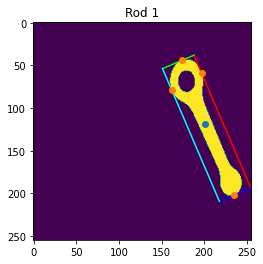

Rod 1 -> Length = 169.25454999552662, Width = 40.048045780309124
Rod 2 -> Length = 131.74290663536496, Width = 27.18983876026428
Rod 3 -> Length = 177.5453668475805, Width = 38.32584799770197


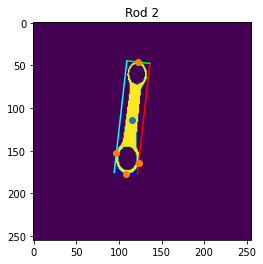

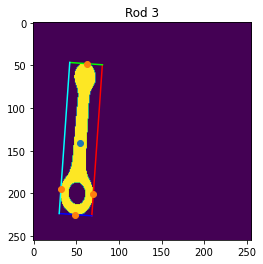

In [60]:
for rod in rods_insp.analyze():
    length, width = rod.mer(draw=True)
    print("Rod {} -> Length = {}, Width = {}".format(rod.label, length, width))

## Width at the barycenter

The width at the barycenter is the width of the rod considering not the whole object but only its barycenter.  
From this observation it can be derived that we're interested in the **two points** of the rod **along** the **minor axis** which are the **farest from** the **barycenter** in both the directions.  
The width at the barycenter is nothing else than the **distance between them**.

In [61]:
class Rod:
    def __init__(self, label, rod_image, rod_centroid):
        self.label = label
        self.image = rod_image
        self.position = Point(rod_centroid[0], rod_centroid[1])
        self.covariance = covariance_matrix(self.image, rod_centroid)
        eigenvalues, eigenvectors = np.linalg.eig(self.covariance)
        beta, alpha = eigenvectors[:, np.argsort(eigenvalues)[::-1][0]]
        self.major_axis = Line(alpha, -beta, beta * self.position.j - alpha * self.position.i)
        self.minor_axis = Line(beta, alpha, -beta * self.position.i - alpha * self.position.j)

    # ...    
        
    def barycenter_width(self):
        height, width = self.image.shape
        
        points = self.minor_axis.evaluate(0, height)
        
        min_barycentre_distance = math.inf
        max_barycentre_distance = -math.inf
        
        b1 = None
        b2 = None
        
        for i, j in points:
            if 0 <= i < height and 0 <= j < width and self.image[i, j] == 255:
                p = Point(i, j)
                major_axis_distance = self.major_axis.distance(p)
                if major_axis_distance < min_barycentre_distance:
                    min_barycentre_distance = major_axis_distance
                    b1 = p
                if major_axis_distance > max_barycentre_distance:
                    max_barycentre_distance = major_axis_distance
                    b2 = p
        return [b1, b2], math.sqrt(((b1.i - b2.i) ** 2) + ((b1.j - b2.j) ** 2))

Rod 1 -> Width at the barycenter = 15.231546211727817
Rod 2 -> Width at the barycenter = 13.038404810405298
Rod 3 -> Width at the barycenter = 14.035668847618199


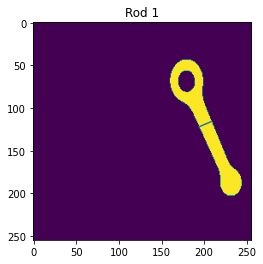

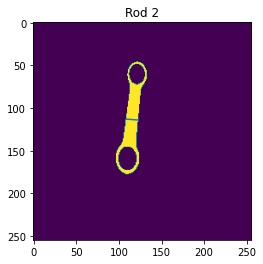

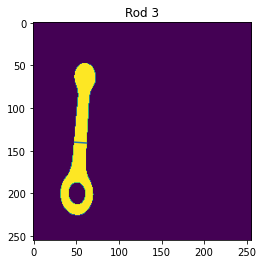

In [62]:
for rod in rods_insp.analyze():
    [b1, b2], bar_width = rod.barycenter_width()
    plt.figure()
    plt.title("Rod {}".format(rod.label))
    plt.plot([b1.j, b2.j], [b1.i, b2.i])
    plt.imshow(rod.image)
    print("Rod {} -> Width at the barycenter = {}".format(rod.label, bar_width))

## Final Result

In the same folder of this notebook there is the **complete source code** of the **classes** we have **analyzed piece by piece** to discuss how to extract all the desired information from the original image.  
Now we will use those classes to obtain a complete overview of the rods.

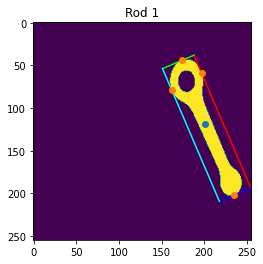

Rod 1:
- Type A
- Position = [201.38639162561577, 119.11915024630542]
- Orientation = -66.80659680708865°
- Length = 169.25454999552662
- Width = 40.048045780309124
- Width at the barycenter = 15.231546149303341
- Hole 1: Center = [179.00777202  68.75647668], Diameter = 22.16913314200113
Rod 2:
- Type B
- Position = [115.21849865951742, 114.17828418230563]
- Orientation = 83.509364849678°
- Length = 131.74290663536496
- Width = 27.18983876026428
- Width at the barycenter = 13.029715302834404
- Hole 1: Center = [121.14327485  60.35087719], Diameter = 20.867389014906145
- Hole 2: Center = [109.95670996 158.97186147], Diameter = 24.253590861306396
Rod 3:
- Type A
- Position = [54.82695252679939, 141.36202143950996]
- Orientation = 86.00214307442056°
- Length = 177.5453668475805
- Width = 38.32584799770197
- Width at the barycenter = 14.035652383079938
- Hole 1: Center = [ 50.96632124 199.93264249], Diameter = 22.16913314200113


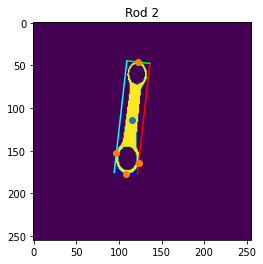

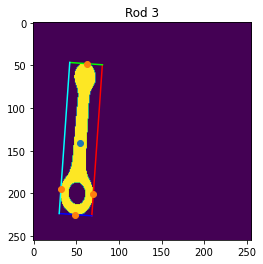

In [63]:
from RodsInspector import RodsInspector

rods_insp = RodsInspector(bin_image)

for rod in rods_insp.analyze():
    rod_type, holes = rod.type()
    length, width = rod.mer(draw=True)
    print("Rod {}:".format(rod.label))
    print("- Type {}".format(rod_type))
    print("- Position = [{}, {}]".format(rod.position.i, rod.position.j))
    print("- Orientation = {}°".format(rod.orientation()))
    print("- Length = {}".format(length))
    print("- Width = {}".format(width))
    print("- Width at the barycenter = {}".format(rod.barycenter_width()))
    for hole in holes:
        print("- Hole {}: Center = {}, Diameter = {}".format(hole['label'], hole['center'], hole['diameter']))

# Second Task

The provided images present alternatively:

1. Some distractor elements like screws and washers
2. Rods with contact points
3. Noise due to iron powder

Trying to perform the **first task** on these kind of images result in a **failure** because **some connected components** are:

1. Not rods
2. Multiple rods connected
3. Noise particles

Being able to deal with **all** the presented **problems simultaneously** is **unlikely**; in fact, they are **related** to pretty **different aspects** and need to be **solved separately**.  
I have **decided** to **concentrate** on a solution for the **first** and the **third problem**.

In [64]:
path = "../images/"
images_problem1 = ["TESI44.BMP", "TESI47.BMP", "TESI48.BMP", "TESI49.BMP"]
# images_problem2 = ["TESI50.BMP", "TESI51.BMP"]
images_problem3 = ["TESI90.BMP", "TESI92.BMP", "TESI98.BMP"]

## First Problem

Detecting blobs not corresponding to a rod is an activity which can be **dealt with** only **while extracting information** about the rod because, until that moment, screws and washers are potential interesting elements and any preprocessing activity trying to remove them can do the same for real rods.  
One possible solution to this problem is **considering** the two **distractors separately** and find a method to **detect** them **indipendently**.

### Screws

In this case a partial solution is already achieved by the first task, in fact, if a rod doesn't present any hole an exception is thrown.  
Starting from this point, we can consider a **screw** like a **rod without any holes**.

In [65]:
class Rod:
    def __init__(self, label, rod_image, rod_centroid):
        self.label = label
        self.image = rod_image
        self.position = Point(rod_centroid[0], rod_centroid[1])
        self.covariance = covariance_matrix(self.image, self.position)
        eigenvalues, eigenvectors = np.linalg.eig(self.covariance)
        beta, alpha = eigenvectors[:, np.argsort(eigenvalues)[::-1][0]]
        self.minor_axis = Line(beta, alpha, -beta * self.position.i - alpha * self.position.j)
        self.major_axis = Line(alpha, -beta, beta * self.position.j - alpha * self.position.i)

    def type(self):
        holes_image = np.array(255 - self.image, dtype=np.uint8)
        holes_num_labels, holes_labelled_image, holes_stats, holes_centroids = \
            cv2.connectedComponentsWithStats(holes_image, cv2.CV_32S, connectivity=4)

        # Don't consider the background and the rod,
        # which are ideally the connected components with largest area
        ignored_labels = (np.argsort(holes_stats[:, 4])[::-1])[0:2]
        true_holes_labels = set(np.unique(holes_labelled_image)) - set(ignored_labels)

        holes = []
        for label in true_holes_labels:
            center = holes_centroids[label]
            diameter = math.sqrt((holes_stats[label, 4] / math.pi)) * 2
            holes.append({"label": label - 1, "center": center, "diameter": diameter})

        num_true_holes = len(true_holes_labels)
        if num_true_holes == 0:
            return "S", holes  # screw
        elif num_true_holes == 1:
            return "A", holes
        elif num_true_holes == 2:
            return "B", holes
        else:
            raise Exception("Unknown object.")

    # ...

### Washers

For the washers the same reasoning cannot be applied since they **present an hole** and **would be classified** as rods of **type A**.  
However, in this case, we can **take advantage** of the **shape** of this kind of objects which is inherently **circular** while rods tends to be more elongated.  
Using **Haralick's circularity** as a **measure** of the **compactness** of a blob, we can separate washers from rods of type A.  
Considering $d_{k} = \sqrt{(i_{k} - i_{b})^2 + (j_{k} - j_{b})^{2}}$ as the **distance** between any **point** $(i_{k}, j_{k})$ belonging to the **contour** of an object, its Haralick's circularity is given by the following formulas, which are scale invariant:

$$ \tilde{C} = \frac{\mu_{R}}{\sigma_{R}} \qquad \mu_{R} = \frac{\sum_{k = 1}^{m} d_{k}}{m} \qquad \sigma_{R} = \sqrt{\frac{\sum_{k = 1}^{m} (d_{k} - \mu_{R})^2}{m}} $$

Since we're interested in contour points, the **first step** to calculate the circularity is to **find** the **points** which constitute the **perimeter** of the object.

In [66]:
class Contour:
    def __init__(self, bin_image):
        contours, _ = cv2.findContours(bin_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.image = np.zeros(bin_image.shape)
        self.points = []
        for shape in range(0, len(contours)):
            for point in range(0, len(contours[shape])):
                i = contours[shape][point][0][1]
                j = contours[shape][point][0][0]
                self.image[i, j] = 255
                self.points.append(Point(i, j))

Let's see a **comparison** between the **binarized images** affected by the first problem and the **image of** the **contours** of their objects.

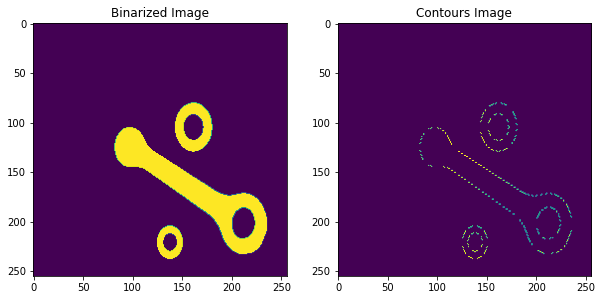

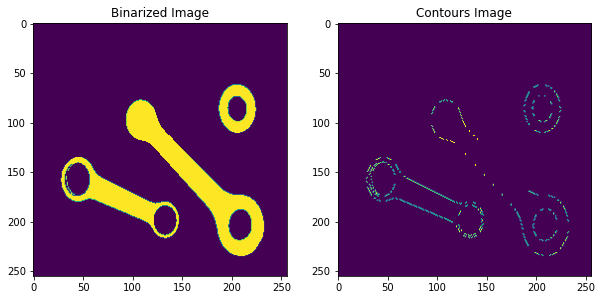

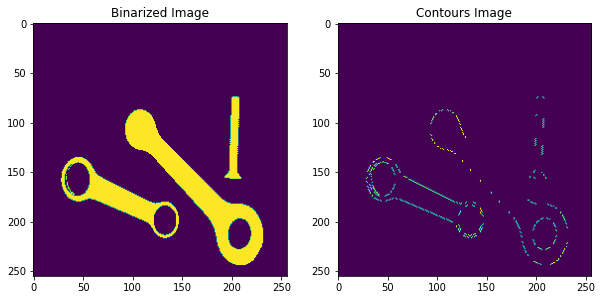

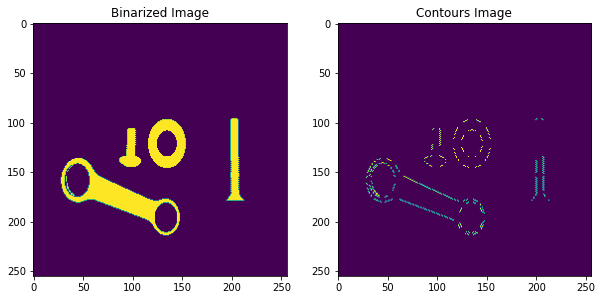

In [67]:
for image in images_problem1:
    image_problem_path = path + image
    image_problem = cv2.imread(image_problem_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(10, 10))
    
    _, bin_image_problem = cv2.threshold(image_problem, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    plt.subplot(1, 2, 1)
    plt.title("Binarized Image")
    plt.imshow(bin_image_problem)
    
    contour = Contour(bin_image_problem)
    plt.subplot(1, 2, 2)
    plt.title("Contours Image")
    plt.imshow(contour.image)
    
    plt.show()

Now we can **compute** the **Haralick's circularity** for **each connected component** supposed to be a rod of type A and setting a proper **threshold** we can **filter out** the **washers**.

In [68]:
def haralick_circularity(bin_image, barycenter):
    contour = Contour(bin_image)
    dist = []
    for p in contour.points:
        dist.append(math.sqrt((p.i - barycenter.i) ** 2 + (p.j - barycenter.j) ** 2))
    dist = np.array(dist)
    mean = dist.sum() / contour.size
    std_dev = math.sqrt(((dist - mean) ** 2).sum() / contour.size)
    return mean / std_dev

In [69]:
class Rod:
    def __init__(self, label, rod_image, rod_centroid):
        self.label = label
        self.image = rod_image
        self.position = Point(rod_centroid[0], rod_centroid[1])
        self.covariance = covariance_matrix(self.image, self.position)
        eigenvalues, eigenvectors = np.linalg.eig(self.covariance)
        beta, alpha = eigenvectors[:, np.argsort(eigenvalues)[::-1][0]]
        self.minor_axis = Line(beta, alpha, -beta * self.position.i - alpha * self.position.j)
        self.major_axis = Line(alpha, -beta, beta * self.position.j - alpha * self.position.i)

    def type(self):
        holes_image = np.array(255 - self.image, dtype=np.uint8)
        holes_num_labels, holes_labelled_image, holes_stats, holes_centroids = \
            cv2.connectedComponentsWithStats(holes_image, cv2.CV_32S, connectivity=4)

        # Don't consider the background and the rod,
        # which are ideally the connected components with largest area
        ignored_labels = (np.argsort(holes_stats[:, 4])[::-1])[0:2]
        true_holes_labels = set(np.unique(holes_labelled_image)) - set(ignored_labels)

        holes = []
        for label in true_holes_labels:
            center = holes_centroids[label]
            diameter = math.sqrt((holes_stats[label, 4] / math.pi)) * 2
            holes.append({"label": label - 1, "center": center, "diameter": diameter})

        num_true_holes = len(true_holes_labels)
        if num_true_holes == 0:
            return "S", holes  # screw
        elif num_true_holes == 1:
            circularity = haralick_circularity(self.image, self.position)
            threshold = 1
            if circularity < threshold:
                return "A", holes
            else:
                return "W", holes  # washer
        elif num_true_holes == 2:
            return "B", holes
        else:
            raise Exception("Unknown object.")
            
    # ...

As the last step to prove the correct classification of objects, let's analyze one of the presented images. I've decided to select the **last one** because it is the **only** with **both screws** and **washers** but the process can be safely repeated for the others.

Object 1 -> Washer
Object 2 -> Screw
Object 3 -> Screw
Rod 4:
- Type B
- Position = [83.31423757371525, 173.86941870261163]
- Orientation = -23.01871255240241°
- Length = 128.40881386108447
- Width = 43.09550497555942
- Width at the barycenter = 20.615420596437446
- Hole 1: Center = [ 44.88851913 157.5374376 ], Diameter = 27.66255531193445
- Hole 2: Center = [133.5        195.44528302], Diameter = 25.977239243415305



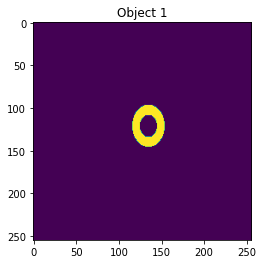

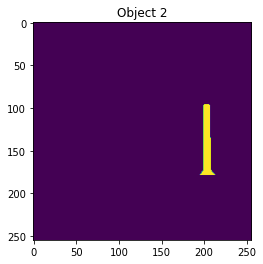

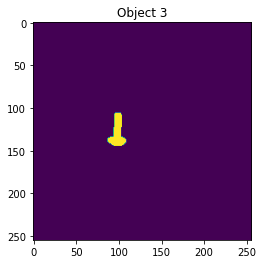

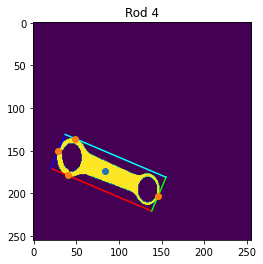

In [70]:
idx = 3
image_problem1_path = path + images_problem1[idx]
image_problem1 = cv2.imread(image_problem1_path, cv2.IMREAD_GRAYSCALE)

_, bin_image_problem1 = cv2.threshold(image_problem1, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
struct_elem = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_image_problem1 = cv2.morphologyEx(bin_image_problem1, cv2.MORPH_CLOSE, struct_elem)
    
rods_insp = RodsInspector(bin_image_problem1)

for rod in rods_insp.analyze():
    rod_type, holes = rod.type()
    
    if rod_type == "S":
        plt.figure()
        plt.title("Object {}".format(rod.label))
        plt.imshow(rod.image)
        print("Object {} -> Screw".format(rod.label))
    
    if rod_type == "W":
        plt.figure()
        plt.title("Object {}".format(rod.label))
        plt.imshow(rod.image)
        print("Object {} -> Washer".format(rod.label))
        
    if rod_type == "A" or rod_type == "B":
        length, width = rod.mer(draw=True)
        print("Rod {}:".format(rod.label))
        print("- Type {}".format(rod_type))
        print("- Position = [{}, {}]".format(rod.position.i, rod.position.j))
        print("- Orientation = {}°".format(rod.orientation()))
        print("- Length = {}".format(length))
        print("- Width = {}".format(width))
        print("- Width at the barycenter = {}".format(rod.barycenter_width()))
        for hole in holes:
            print("- Hole {}: Center = {}, Diameter = {}".format(hole['label'], hole['center'], hole['diameter']))
        print()

## Third Problem

The **first idea** can be to **erode** the image and **then dilate** it, performing the **morphology operation** known as **opening**.

In [71]:
def opening_preprocessing(image, struct_elem=cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))):
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, struct_elem)

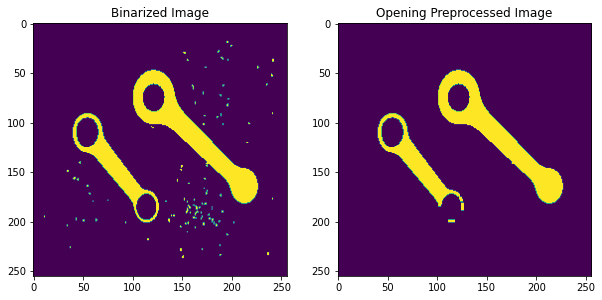

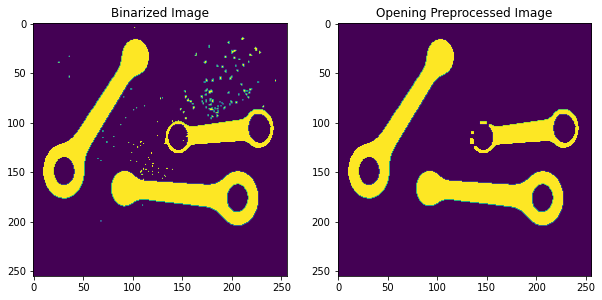

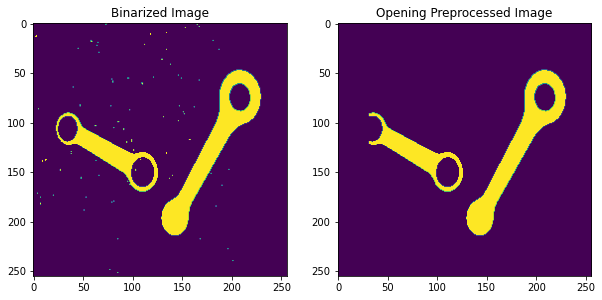

In [72]:
for image in images_problem3:
    image_problem3_path = path + image
    image_problem3 = cv2.imread(image_problem3_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(10, 10))
    
    _, bin_image_problem3 = cv2.threshold(image_problem3, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    plt.subplot(1, 2, 1)
    plt.title("Binarized Image")
    plt.imshow(bin_image_problem3)
    
    prepr_image = opening_preprocessing(bin_image_problem3)
    plt.subplot(1, 2, 2)
    plt.title("Opening Preprocessed Image")
    plt.imshow(prepr_image)
    
    plt.show()

Like we can observe, this approach is strictly **image-dependent** and despite being able to **remove** the **noise**, it also results in a **partial rod wiping** when the part of the rod around the holes is not particularly thick.  
We **need** a **more robust method** which can **preserve** the **rod shape** while performing the cleaning.  
The solution I opted for consists in applying multiple times a **mean filter** to the image.

In [73]:
def mean_filter_preprocessing(image, size=3, iterations=5):
    prepr_image = image.copy()
    for i in range(0, iterations):
        prepr_image = cv2.medianBlur(prepr_image, size)
    return prepr_image

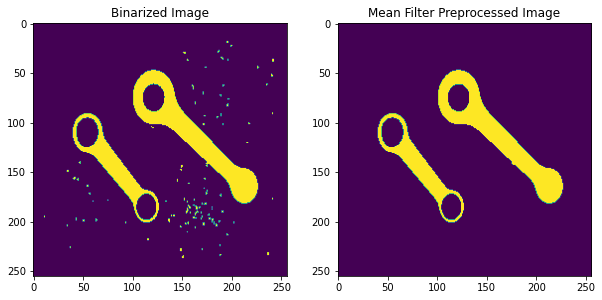

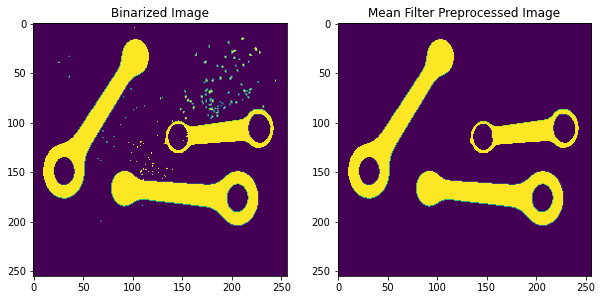

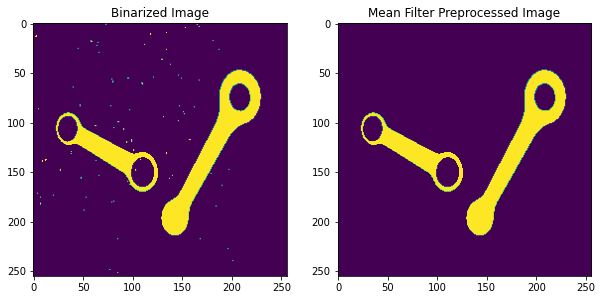

In [74]:
for image in images_problem3:
    image_problem3_path = path + image
    image_problem3 = cv2.imread(image_problem3_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(10, 10))
    
    _, bin_image_problem3 = cv2.threshold(image_problem3, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    plt.subplot(1, 2, 1)
    plt.title("Binarized Image")
    plt.imshow(bin_image_problem3)
    
    prepr_image = mean_filter_preprocessing(bin_image_problem3)
    plt.subplot(1, 2, 2)
    plt.title("Mean Filter Preprocessed Image")
    plt.imshow(prepr_image)
    
    plt.show()

Despite being so simple, this approach **performs really well** and seems to be **robust to noise** size; this is probably due to the **small kernel dimensions**, which don't let holes border disappear, and the **iterative process**: **noise** is **increasingly removed** until totally disappering and **then** the **convolution** on the cleaned image is **idempotent**.

As a final proof of the effectiveness of the cleaning operations, let's analyze the rods inside one of the above images.

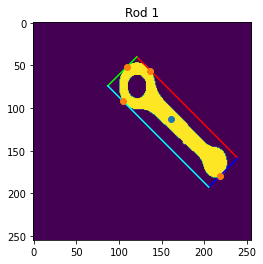

Rod 1:
- Type A
- Position = [160.64882172131146, 112.79098360655738]
- Orientation = -45.08587995788492°
- Length = 167.60425648465008
- Width = 48.07896761323398
- Width at the barycenter = 18.38475565863448
- Hole 1: Center = [121.10515021  74.8583691 ], Diameter = 24.35835848013133
Rod 2:
- Type B
- Position = [81.18342541436463, 143.2779005524862]
- Orientation = -51.90510808945343°
- Length = 127.84247460483274
- Width = 33.97185495459695
- Width at the barycenter = 16.40052753333577
- Hole 1: Center = [ 54.1969112  109.67374517], Diameter = 25.68147355921802
- Hole 2: Center = [113.79268293 184.67560976], Diameter = 22.847936741452536


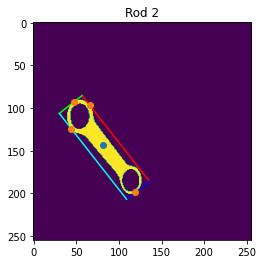

In [75]:
idx = 0
image_problem3_path = path + images_problem3[idx]
image_problem3 = cv2.imread(image_problem3_path, cv2.IMREAD_GRAYSCALE)

_, bin_image_problem3 = cv2.threshold(image_problem3, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
prepr_image = mean_filter_preprocessing(bin_image_problem3)

rods_insp = RodsInspector(prepr_image)

for rod in rods_insp.analyze():
    rod_type, holes = rod.type()
    length, width = rod.mer(draw=True)
    print("Rod {}:".format(rod.label))
    print("- Type {}".format(rod_type))
    print("- Position = [{}, {}]".format(rod.position.i, rod.position.j))
    print("- Orientation = {}°".format(rod.orientation()))
    print("- Length = {}".format(length))
    print("- Width = {}".format(width))
    print("- Width at the barycenter = {}".format(rod.barycenter_width()))
    for hole in holes:
        print("- Hole {}: Center = {}, Diameter = {}".format(hole['label'], hole['center'], hole['diameter']))